In [1]:
# Set up the libraries and load data
import pandas as pd
import numpy as np
from sklearn.linear_model import LassoCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

prop_df = pd.read_csv('airbnb_cleaned.csv.gz')

# List of predictors
predictor_list = ['host_is_superhost', 'host_identity_verified', 'bedrooms',
                  'beds', 'price', 'instant_bookable', 
                  'am_free_street_parking', 'am_patio_or_balcony', 
                  'am_lockbox', 'am_extra_pillows_and_blankets',
                  'am_refrigerator', 'am_hair_dryer',
                  'am_security_cameras_on_property', 'am_cooking_basics', 
                  'am_luggage_dropoff_allowed', 'am_coffee_maker', 
                  'am_bed_linens', 'am_first_aid_kit', 'am_oven', 
                  'am_backyard', 'am_freezer', 'am_microwave',
                  'am_long_term_stays_allowed', 'am_shampoo', 'am_body_soap',
                  'am_bathtub', 'am_free_parking_on_premises', 'am_hangers',
                  'am_dishes_and_silverware', 'am_private_entrance', 
                  'am_hot_water', 'am_stove', 'am_dishwasher', 
                  'am_dedicated_workspace', 'am_iron', 
                  'am_lock_on_bedroom_door', 'am_carbon_monoxide_alarm', 
                  'am_dryer', 'am_washer', 'am_keypad', 'am_indoor_fireplace', 
                  'am_fire_extinguisher', 'am_room_darkening_shades', 
                  'am_shower_gel', 'am_conditioner', 
                  'am_baking_sheet', 'am_pool', 'am_gym', 'am_elevator', 
                  'am_bbq_grill', 'desc_length', 'neigh_desc_length',
                  'host_desc_length', 'host_neigh_present', 'host_since_days',
                  'room_type_entire_home_apt', 'room_type_hotel_room',
                  'room_type_private_room', 'host_many_listings', 
                  'city_austin', 'city_boston', 'city_chicago',
                  'month_april', 'month_july', 'month_october']

# Clean up predictor names for plots
# Function to clean up names
def pred_name_clean(pred_name):
    
    '''Returns a more readable label based on variable name.'''
    
    pred_name = pred_name.replace('am_', '')
    pred_name = pred_name.replace('city_', '')
    pred_name = pred_name.replace('month_', '')
    pred_name = pred_name.replace('_', ' ')
    pred_name = pred_name.replace('desc', 'description')
    pred_name = pred_name.replace('neigh', 'neighborhood')
    pred_name = pred_name.replace('room type', 'Room type:')
    pred_name = pred_name.capitalize()
    return(pred_name)

# Create a data frame with labels for predictors
predictor_labels = pd.DataFrame({'predictor_name': predictor_list,
                                 'predictor_label': [pred_name_clean(p) for p
                                                     in predictor_list]})

# Categorize predictors into groups for easier display later
pred_conds = [predictor_labels['predictor_name'].str.startswith('am_'), 
              predictor_labels['predictor_name'].str.startswith('city_'),
              predictor_labels['predictor_name'].str.startswith('month_'),
              predictor_labels['predictor_name'].str.startswith('host_'),
              predictor_labels['predictor_name'].isin(['bedrooms', 'beds', 
                                                     'price', 
                                                     'instant_bookable',
                                                     'desc_length', 
                                                     'neigh_desc_length']),
              predictor_labels['predictor_name'].str.startswith('room_type_')]
pred_choices = ['Amenity', 'City', 'Month', 'Host', 'Property features',
                'Property features']

predictor_labels['predictor_type'] = np.select(pred_conds, pred_choices)


C:\Users\shiri\miniconda3\lib\site-packages\IPython\core\interactiveshell.py:3172: DtypeWarning: Columns (8) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


This notebook performs the analysis of Airbnb data. In the analysis, we'll examine the reviews for Airbnb properties and try to figure out which features of properties or their hosts can predict user ratings and the sentiment of user reviews. The data used here are for four U.S. cities, Austin, Boston, Chicago, and Portland, but it can be very easily expanded to other cities and countries available on the Airbnb Get the data page. Similarly, the data selected for the analysis represent four months in 2021 (January, April, July, and September), but it's straightforward to include other months.

The next block of code sets up a function to run regression models. In this analysis, we will use lasso regression with 10-fold cross-validation to determine the optimal alpha parameter (penalty). The model is trained on a subsample of Airbnb data (70%) and then validated using a test sample.

In [23]:
# Function to run a lasso regression and return coefficients
def run_lasso(y_var, city='all', month='all', show_r2_alpha=True):
    
    '''
    Creates a matrix of predictors and the outcome variable for a given city
    or month, then runs a lasso regression on this set of predictors
    and returns the alpha value, R^2, and model coefficients.
    '''
    
    
    # Set up X and y
    if city == 'all' and month == 'all':
        y = prop_df[y_var]
        X = prop_df[predictor_list]
    else:
        if city != 'all':
            city_dummy = 'city_' + city
            y = prop_df[prop_df[city_dummy] == 1][y_var]
            X = prop_df[prop_df[city_dummy] == 1][predictor_list]
        if month != 'all':
            month_dummy = 'month_' + month
            y = prop_df[prop_df[month_dummy] == 1][y_var]
            X = prop_df[prop_df[month_dummy] == 1][predictor_list]
                
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.30, 
                                                        random_state=42)
    
    # Instantiate the model, normalizing the predictors
    lm_model = make_pipeline(StandardScaler(with_mean=False), 
                             LassoCV(cv=10, random_state=42))
    
    # Run the model
    lm_model.fit(X, y)
    
    # Predictions for the test set
    y_test_preds = lm_model.predict(X_test)
    
    # Extract model coefficients
    lasso_coefs = pd.DataFrame(
        {'feature': list(X.columns),
         'coef': lm_model.named_steps['lassocv'].coef_
        }, index=list(X.columns))
    lasso_coefs = pd.merge(
        lasso_coefs, predictor_labels, left_on='feature', 
        right_on='predictor_name',
        how='left'
        ).drop(columns=['predictor_name'])
    
    if show_r2_alpha:        
        # R^2 for the test set
        r2_test = r2_score(y_test, y_test_preds)
        
        # Extract optimal alpha suggested by cross-validation
        lasso_alpha = lm_model.named_steps['lassocv'].alpha_
        
        return(lasso_alpha, r2_test, lasso_coefs)
    
    else:        
        return(lasso_coefs)


First, we'll run the model on the full sample of our data. The following lines return the alpha parameter selected by cross-validation, the R-squared on the test set, and a data frame of lasso coefficients with predictor labels for easier plotting.

In [24]:
# Predicting review scores
rating_alpha, rating_r2, rating_coefs = run_lasso('review_scores_rating')

# Predicting sentiment
sent_alpha, sent_r2, sent_coefs = run_lasso('rev_sent')

Here's the alpha selected for the model that predicts the overall user rating and the R-squared for this model. We can see that the model explains about 10 percent of the variation in user ratings, which is not a lot.

In [25]:
print("Alpha: " + str(round(rating_alpha, 6)))
print("R2: " + str(round(rating_r2, 4)))

Alpha: 0.000978
R2: 0.101


And here's the same for the model that predicts user review sentiment. This model has a bit more explanatory power (about 16 percent of the variation), but still it does not explain very much. Clearly, there are other factors besides the ones reflected in the data that are relevant to user scores and reviews, which may include, say, the cleanliness of the apartment or the attitude of the host. 

In [26]:
print("Alpha: " + str(round(sent_alpha, 6)))
print("R2: " + str(round(sent_r2, 4)))

Alpha: 0.000154
R2: 0.1608


Nonetheless, let's see which of the available variables are more helpful in explaining our two outcomes related to user reviews. The following plot shows all the coefficients for both models, sorted by size (for the model of user score ratings). We can see that many variables consistently predict both outcomes. Several such variables are host features: hosts who are superhosts and those with a longer experience as hosts receive better ratings and reviews with more positive sentiment, whereas hosts who have many listings receive less positive response. Property features also matter. More expensive lodgings and properties with more detailed (longer) description receive more positive responses, whereas properties that are instantly bookable and those that allow long-term stay are evaluated less positively. In addition, time of the year and city also matter; properties rented in July and October and those situated in Boston and Chicago are perceived less positively.

[Text(0, 0.5, ''), Text(0.5, 1.0, 'Lasso Coefficients')]

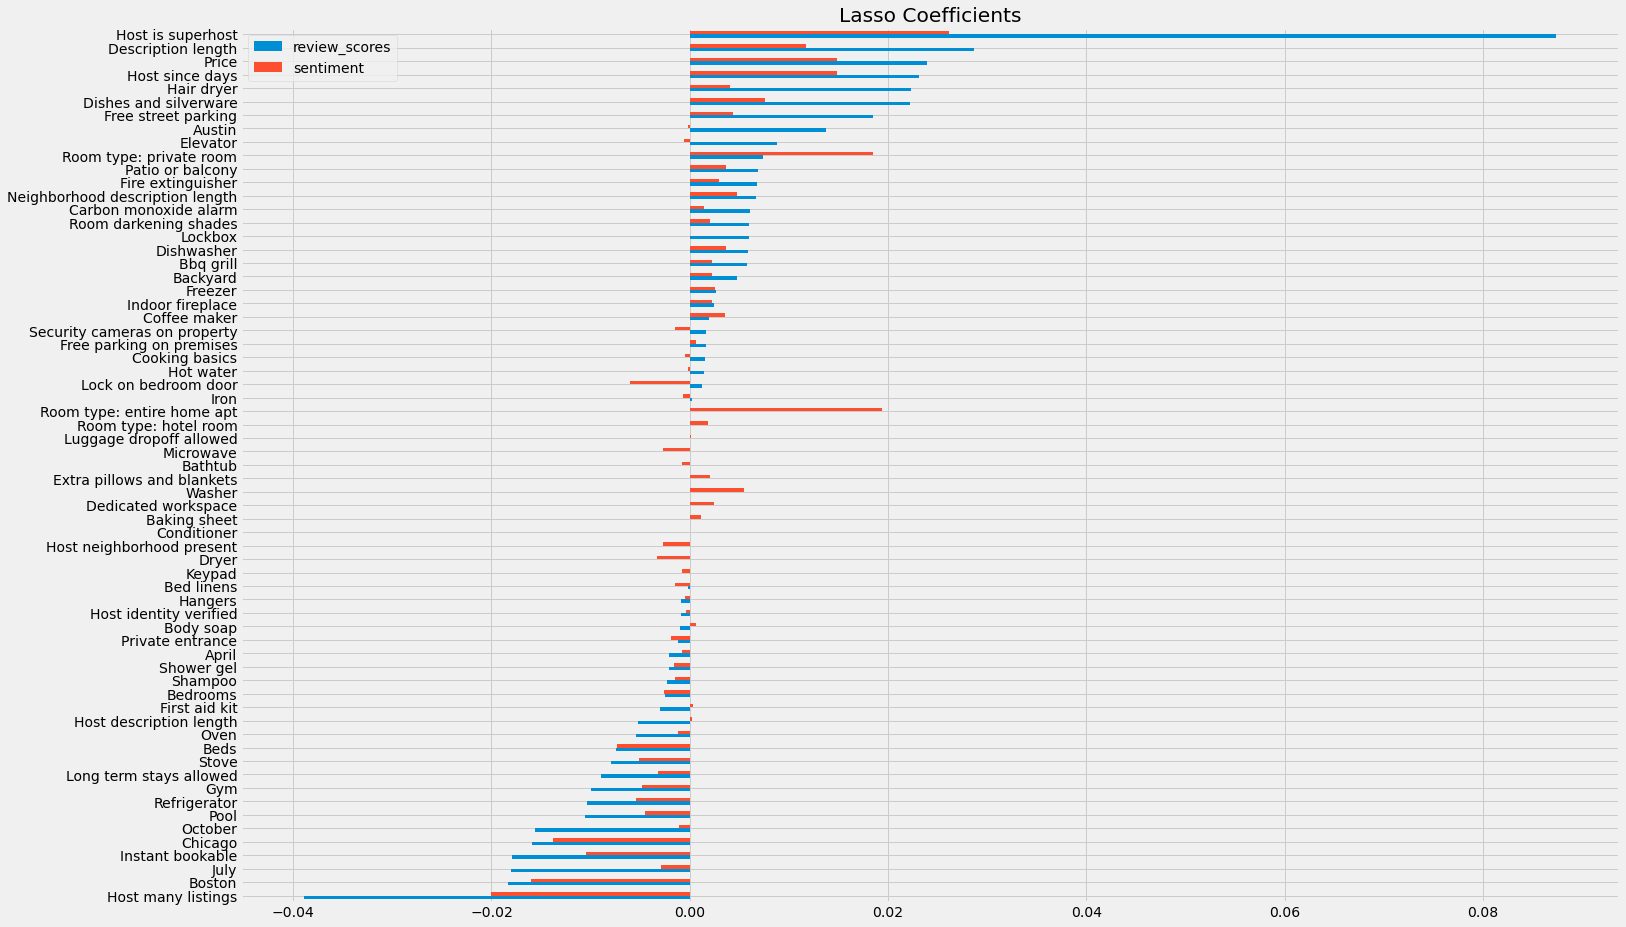

In [27]:
# Merge coefficients from two models and add variable labels
all_coefs = pd.merge(rating_coefs, sent_coefs, 
                     on=['feature',
                         'predictor_label',
                         'predictor_type'],
                     how='left').set_index('predictor_label')
all_coefs = all_coefs.rename(columns={'coef_x': 'review_scores', 
                                      'coef_y': 'sentiment'})
all_coefs = all_coefs.sort_values(by=['review_scores'])

# Plot
plt.style.use('fivethirtyeight')
plot_coefs = all_coefs.plot.barh(figsize=(22,15))
plot_coefs.set(ylabel='', title='Lasso Coefficients')

Now, let's see whether the importance of predictors varies across cities. The following runs the same model, but separately on the each city subsample.

In [28]:
# Analysis by city
# Predicting review scores
rating_coefs_a = run_lasso('review_scores_rating', 'austin', 
                           show_r2_alpha=False)
rating_coefs_b = run_lasso('review_scores_rating', 'boston', 
                           show_r2_alpha=False)
rating_coefs_c = run_lasso('review_scores_rating', 'chicago', 
                           show_r2_alpha=False)
rating_coefs_p = run_lasso('review_scores_rating', 'portland', 
                           show_r2_alpha=False)

dfs = [df.set_index(['feature', 'predictor_label',
                     'predictor_type']) for df in [rating_coefs_a, 
                                                   rating_coefs_b, 
                                                   rating_coefs_c, 
                                                   rating_coefs_p]]
all_coefs_cities = pd.concat(dfs, axis=1).reset_index()
all_coefs_cities.columns.values[[3, 4, 5, 6]] = ['Austin', 'Boston', 
                                                 'Chicago', 'Portland']
all_coefs_cities = all_coefs_cities.set_index('predictor_label')
all_coefs_cities = all_coefs_cities.sort_values(by=['Austin'])


Putting everything on one plot might make things confusing, so we're splitting the predictors into three groups (host-related, general property features, and amenities), and there is a separate plot for each group of variables. We can see that some features are consistently associated with higher ratings (being a superhost, having a longer experience as a host, price, hot water, patio, free street parking) or lower ratings (hosts who have many listings, apartment being instantly bookable, long term stays allowed). The contribution of other features (especially various amenities), however, differs across cities. This makes sense given the differences in climate or the urban environment between cities.

[Text(0, 0.5, ''), Text(0.5, 1.0, 'Lasso coefficients')]

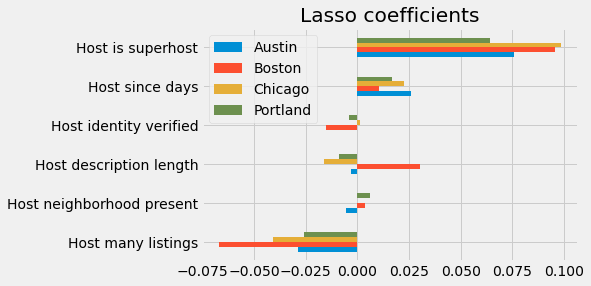

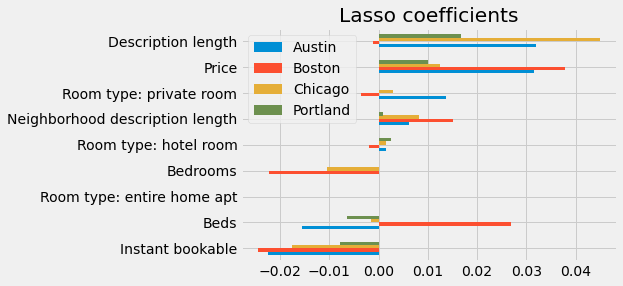

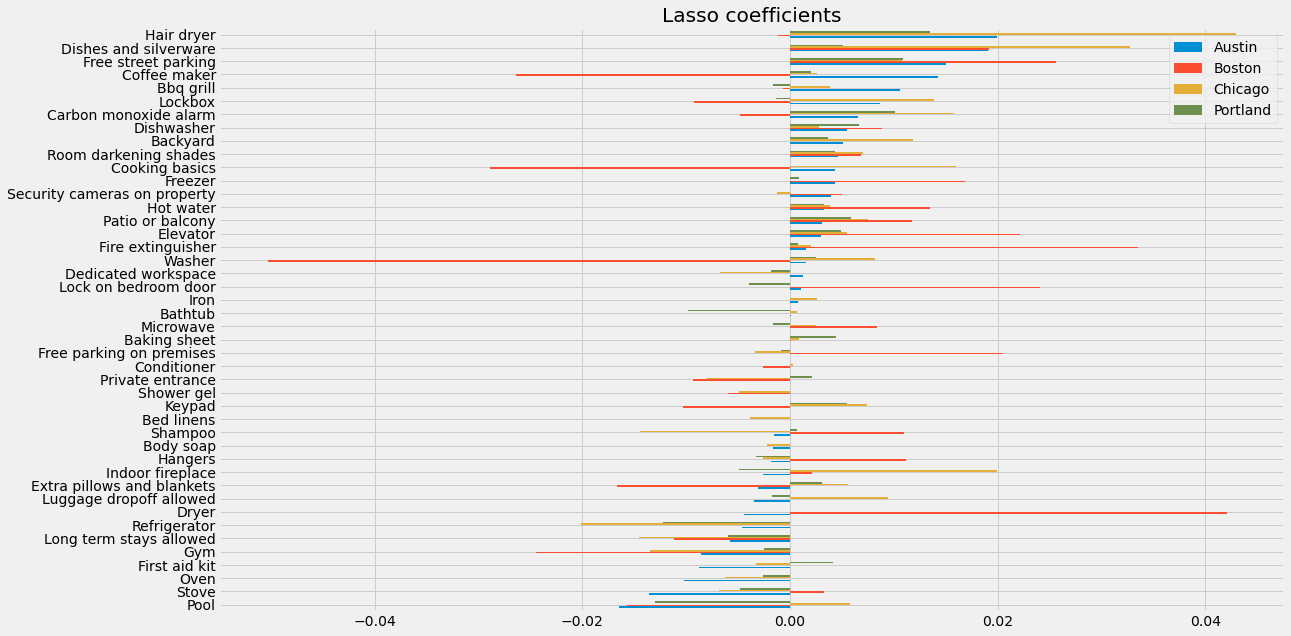

In [29]:
plot_coefs = all_coefs_cities[all_coefs_cities.predictor_type == 'Host'].plot.barh()
plot_coefs.set(ylabel='', title='Lasso coefficients')

plot_coefs = all_coefs_cities[
    all_coefs_cities.predictor_type == 'Property features'
    ].plot.barh()
plot_coefs.set(ylabel='', title='Lasso coefficients')

plot_coefs = all_coefs_cities[
    all_coefs_cities.predictor_type == 'Amenity'
    ].plot.barh(figsize=[17,10])
plot_coefs.set(ylabel='', title='Lasso coefficients')

The following does the same for predictors of review sentiment, and the results are largely similar.

[Text(0, 0.5, ''), Text(0.5, 1.0, 'Lasso coefficients')]

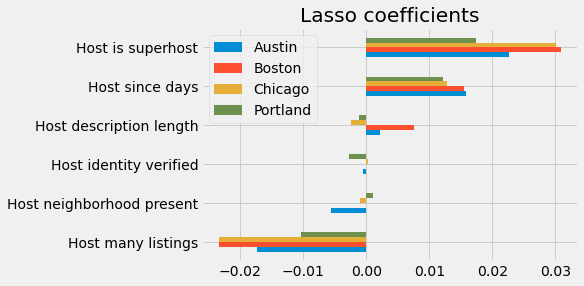

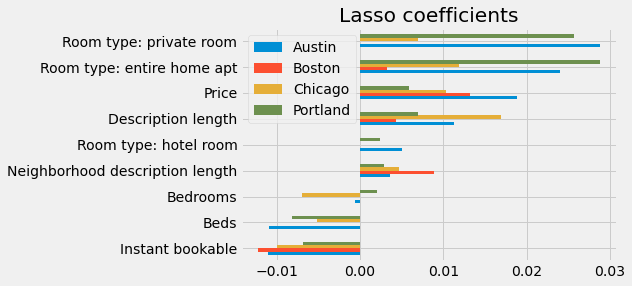

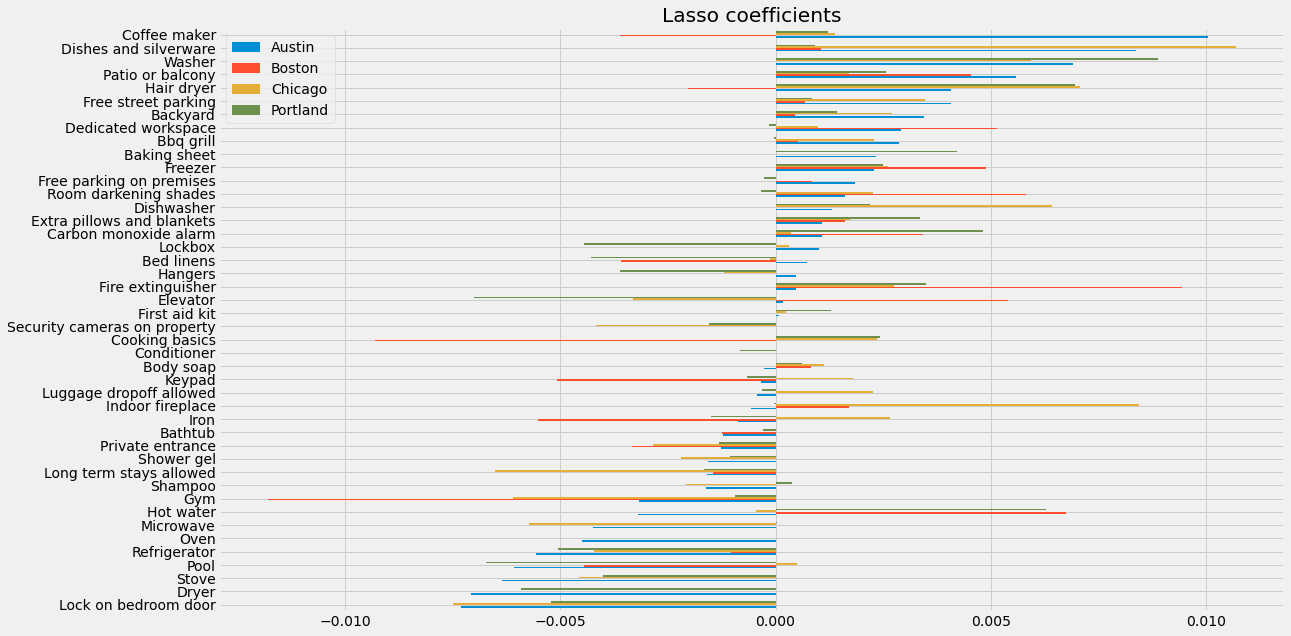

In [30]:
sent_coefs_a = run_lasso('rev_sent', 'austin', show_r2_alpha=False)
sent_coefs_b = run_lasso('rev_sent', 'boston', show_r2_alpha=False)
sent_coefs_c = run_lasso('rev_sent', 'chicago', show_r2_alpha=False)
sent_coefs_p = run_lasso('rev_sent', 'portland', show_r2_alpha=False)

dfs = [df.set_index(['feature', 'predictor_label',
                     'predictor_type']) for df in [sent_coefs_a, 
                                                   sent_coefs_b, 
                                                   sent_coefs_c, 
                                                   sent_coefs_p]]
all_coefs_cities_sent = pd.concat(dfs, axis=1).reset_index()
all_coefs_cities_sent.columns.values[[3, 4, 5, 6]] = ['Austin', 'Boston', 
                                                      'Chicago', 'Portland']
all_coefs_cities_sent = all_coefs_cities_sent.set_index('predictor_label')
all_coefs_cities_sent = all_coefs_cities_sent.sort_values(by=['Austin'])

# Plots
plot_coefs = all_coefs_cities_sent[
    all_coefs_cities_sent.predictor_type == 'Host'
    ].plot.barh()
plot_coefs.set(ylabel='', title='Lasso coefficients')

plot_coefs = all_coefs_cities_sent[
    all_coefs_cities_sent.predictor_type == 'Property features'
    ].plot.barh()
plot_coefs.set(ylabel='', title='Lasso coefficients')

plot_coefs = all_coefs_cities_sent[
    all_coefs_cities_sent.predictor_type == 'Amenity'
    ].plot.barh(figsize=[17,10])
plot_coefs.set(ylabel='', title='Lasso coefficients')

Now let's do the same as above, but instead of splitting the data by cities, we'll split it by month (there are four months currently in the data). First, here are the results for rating scores. Here, there is more consistence across different times of the year than it was across different cities, especially with respect to different amenities, but the impact of most variables still somewhat varies by month.

[Text(0, 0.5, ''), Text(0.5, 1.0, 'Lasso coefficients')]

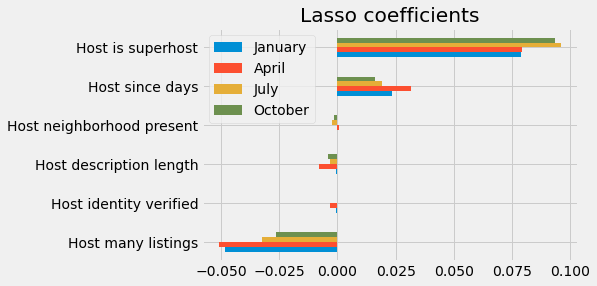

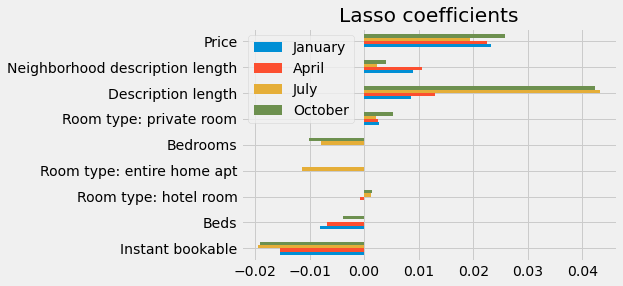

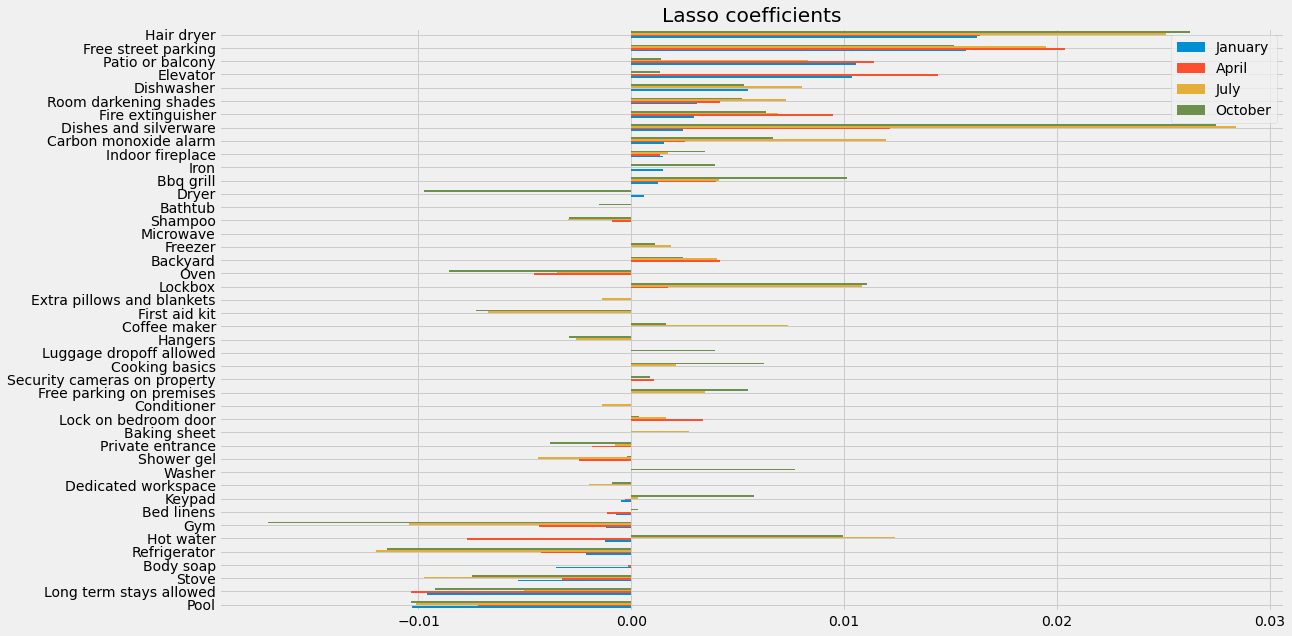

In [31]:
# Analysis by month
# Predicting review scores
rating_coefs_jan = run_lasso('review_scores_rating', month='january', 
                             show_r2_alpha=False)
rating_coefs_apr = run_lasso('review_scores_rating', month='april', 
                             show_r2_alpha=False)
rating_coefs_jul = run_lasso('review_scores_rating', month='july', 
                             show_r2_alpha=False)
rating_coefs_oct = run_lasso('review_scores_rating', month='october', 
                             show_r2_alpha=False)

dfs = [df.set_index(['feature', 'predictor_label',
                     'predictor_type']) for df in [rating_coefs_jan, 
                                                   rating_coefs_apr, 
                                                   rating_coefs_jul, 
                                                   rating_coefs_oct]]
all_coefs_months = pd.concat(dfs, axis=1).reset_index()
all_coefs_months.columns.values[[3, 4, 5, 6]] = ['January', 'April', 
                                                 'July', 'October']
all_coefs_months = all_coefs_months.set_index('predictor_label')
all_coefs_months = all_coefs_months.sort_values(by=['January'])

# Plots
plot_coefs = all_coefs_months[
    all_coefs_months.predictor_type == 'Host'
    ].plot.barh()
plot_coefs.set(ylabel='', title='Lasso coefficients')

plot_coefs = all_coefs_months[
    all_coefs_months.predictor_type == 'Property features'
    ].plot.barh()
plot_coefs.set(ylabel='', title='Lasso coefficients')

plot_coefs = all_coefs_months[
    all_coefs_months.predictor_type == 'Amenity'
    ].plot.barh(figsize=[17,10])
plot_coefs.set(ylabel='', title='Lasso coefficients')


And then the same split by month, but for review sentiment. Again, there is a lot of consistency across months.

[Text(0, 0.5, ''), Text(0.5, 1.0, 'Lasso coefficients')]

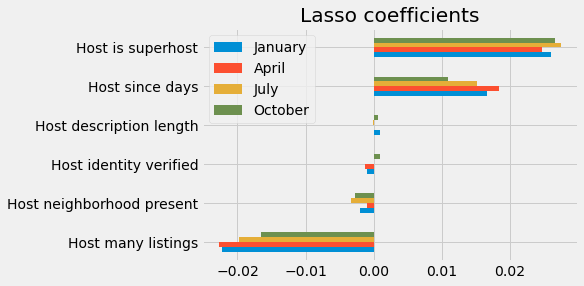

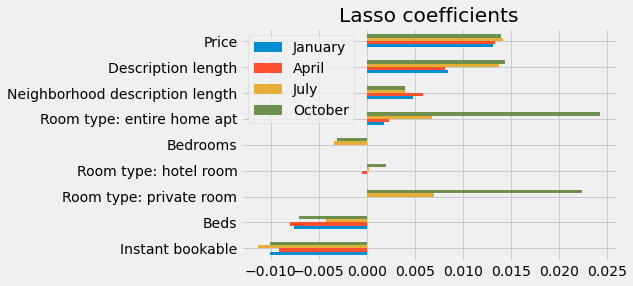

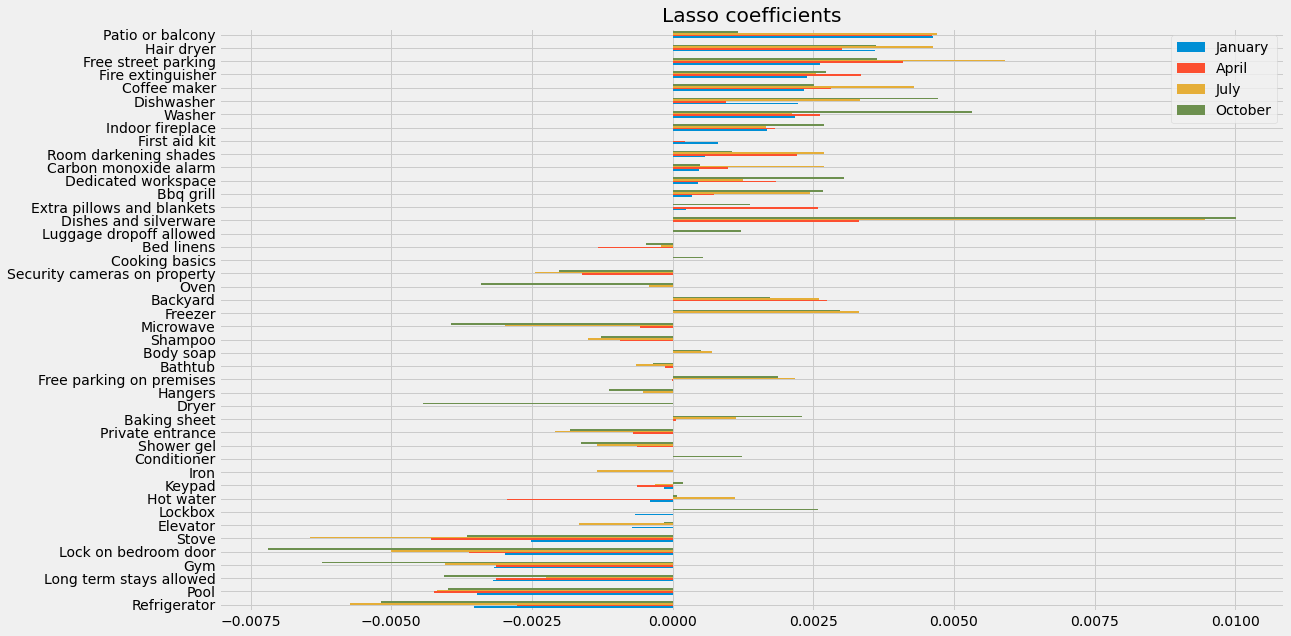

In [32]:
# Predicting review sentiment
sent_coefs_jan = run_lasso('rev_sent', month='january', show_r2_alpha=False)
sent_coefs_apr = run_lasso('rev_sent', month='april', show_r2_alpha=False)
sent_coefs_jul = run_lasso('rev_sent', month='july', show_r2_alpha=False)
sent_coefs_oct = run_lasso('rev_sent', month='october', show_r2_alpha=False)

dfs = [df.set_index(['feature', 'predictor_label',
                     'predictor_type']) for df in [sent_coefs_jan, 
                                                   sent_coefs_apr, 
                                                   sent_coefs_jul, 
                                                   sent_coefs_oct]]
all_coefs_months = pd.concat(dfs, axis=1).reset_index()
all_coefs_months.columns.values[[3, 4, 5, 6]] = ['January', 'April', 
                                                 'July', 'October']
all_coefs_months = all_coefs_months.set_index('predictor_label')
all_coefs_months = all_coefs_months.sort_values(by=['January'])

# Plots
plot_coefs = all_coefs_months[
    all_coefs_months.predictor_type == 'Host'
    ].plot.barh()
plot_coefs.set(ylabel='', title='Lasso coefficients')

plot_coefs = all_coefs_months[
    all_coefs_months.predictor_type == 'Property features'
    ].plot.barh()
plot_coefs.set(ylabel='', title='Lasso coefficients')

plot_coefs = all_coefs_months[
    all_coefs_months.predictor_type == 'Amenity'
    ].plot.barh(figsize=[17,10])
plot_coefs.set(ylabel='', title='Lasso coefficients')
